In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import os
import numpy as np
%load_ext tensorboard

In [2]:
tsla = pd.read_parquet("data/tsla_final2.parquet")

In [3]:
tsla['Change'] = tsla['Open']-tsla['Close']

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler1 = MinMaxScaler(feature_range=(0,1))
tsla['Close'] = scaler.fit_transform(tsla['Close'].values.reshape(-1, 1))
tsla[['Change', 'subjectivity', 'polarity']] = scaler1.fit_transform(tsla[['Change', 'subjectivity', 'polarity']])

X should be 30 days of change, polarity, subjectivity, and close
y should be day 31 close price

In [9]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

prediction_days = 30

X, y = [], []
for x in range(prediction_days, len(tsla)):
    X.append(tsla[['Close', 'Change', 'subjectivity', 'polarity']].iloc[x-prediction_days:x]) #for each iteration, you get 60 day window (x-60 to x) as training data
    y.append(tsla['Close'].iloc[x]) #for each iteration, the label is the last day of window, x

X, y = np.array(X), np.array(y)


In [10]:
X_train, y_train = X[0:800], y[0:800]
X_test, y_test = X[800:], y[800:]
print(y.shape)
print(len(y_train)+len(y_test)) # checks entire dataset is contained here

(1228,)
1228


In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
25/25 [==============================] - 3s 15ms/step - loss: 0.0469
Epoch 2/25
25/25 [==============================] - 0s 14ms/step - loss: 0.0082
Epoch 3/25
25/25 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 4/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0059
Epoch 5/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0059
Epoch 6/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0067
Epoch 7/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0053
Epoch 8/25
25/25 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 9/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0047
Epoch 10/25
25/25 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 11/25
25/25 [==============================] - 0s 18ms/step - loss: 0.0044
Epoch 12/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0042
Epoch 13/25
25/25 [==================

In [12]:
prediction_prices = model.predict(X_train)
prediction_prices = scaler.inverse_transform(prediction_prices)
prediction_prices

array([[43.376987],
       [43.170265],
       [42.92885 ],
       [42.820316],
       [42.925385],
       [42.917618],
       [42.780605],
       [42.541252],
       [42.32255 ],
       [42.010834],
       [41.559307],
       [41.143745],
       [40.88964 ],
       [40.668518],
       [40.31984 ],
       [39.863544],
       [39.46967 ],
       [39.18604 ],
       [38.946785],
       [38.741558],
       [38.661297],
       [38.664127],
       [38.89425 ],
       [39.074432],
       [39.27106 ],
       [39.517242],
       [39.736015],
       [39.823154],
       [39.739033],
       [39.42328 ],
       [39.14631 ],
       [38.83244 ],
       [38.520798],
       [38.30069 ],
       [38.347507],
       [38.617462],
       [38.977783],
       [39.460503],
       [40.05487 ],
       [40.64204 ],
       [41.140385],
       [41.563927],
       [41.86931 ],
       [42.062183],
       [42.13688 ],
       [42.240788],
       [42.554432],
       [42.953384],
       [43.320522],
       [43.920654],


In [16]:
actual_prices = y_train.reshape(-1, 1)
actual_prices = scaler.inverse_transform(actual_prices)
actual_prices

array([[40.86999893],
       [40.89199829],
       [42.34199905],
       [43.42200089],
       [41.4679985 ],
       [40.8219986 ],
       [40.7519989 ],
       [41.43799973],
       [40.66799927],
       [39.4659996 ],
       [39.91199875],
       [40.48799896],
       [40.12599945],
       [38.77600098],
       [38.17599869],
       [38.06399918],
       [38.7480011 ],
       [38.2140007 ],
       [37.73600006],
       [39.13999939],
       [38.94599915],
       [40.14199829],
       [39.13000107],
       [39.61600113],
       [39.92599869],
       [40.34400177],
       [38.86000061],
       [38.08200073],
       [37.        ],
       [38.11399841],
       [37.75400162],
       [37.51800156],
       [38.20000076],
       [40.61999893],
       [40.65000153],
       [41.5340004 ],
       [42.01800156],
       [42.18000031],
       [41.95600128],
       [41.49200058],
       [41.56600189],
       [41.34000015],
       [41.35800171],
       [41.05400085],
       [41.88199997],
       [43

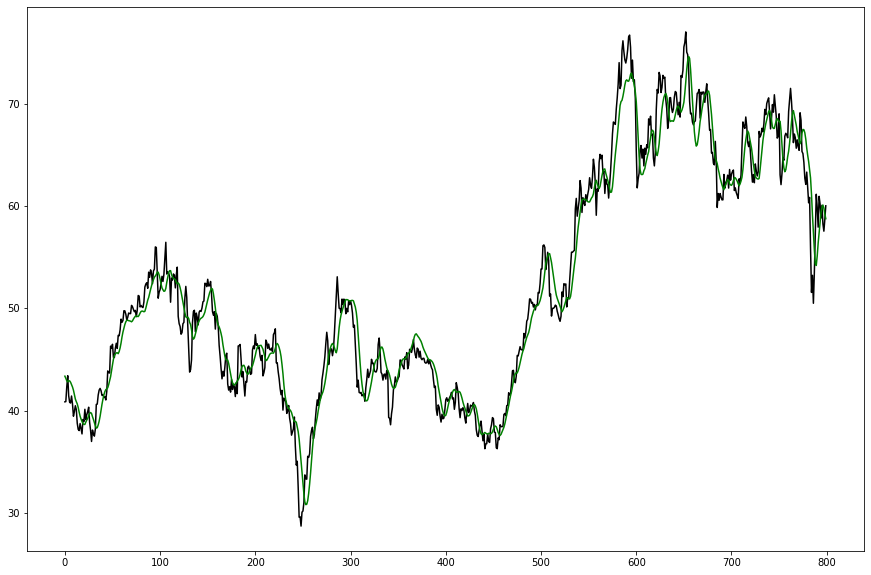

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(actual_prices, color='black')
plt.plot(prediction_prices, color='green', label='Predicted Prices')

plt.show()